In [1]:
import pandas as pd

# init empty lists
data = []
EPC_sep = []
RSSI_min = []
data_new = []
EPC_count_list = []

#init empty dictionary
mapping = {}

# load csv file into dataframe and change header row (deleted everything before)
input = 'Data/REV7/6 Rick Brophy/RB 3m/1 Lat Raise/2024-07-29_10-38-10.csv'
    #print(f'Trying to read csv file: {input}')
data.append(pd.read_csv(input, header = 2))
    
for i in range(len(data)):
    # change which columns are needed and remove spaces
    data[i] = data[i].iloc[0:, [0,1,4,7]]
    data[i].columns = data[i].columns.str.strip()

    # rename columns
    data[i].rename(columns={'// Timestamp' : 'Timestamp'},     inplace = True)
    #data[i].rename(columns={' RSSI'        : 'RSSI'},          inplace = True)
    #data[i].rename(columns={' PhaseAngle'  : 'PhaseAngle'},    inplace = True)
    #data[i].rename(columns={' EPC'         : 'EPC'},           inplace = True)

    '''
    # parse timestamp data and create new column to have comparable time values
    data[i]['Timestamp'] = pd.to_datetime(data[i]['Timestamp'])
    first_timestamp = data[i]['Timestamp'].iloc[0]
    data[i]['TimeElapsed'] = data[i]['Timestamp'] - first_timestamp

    # separate time elapsed into seconds and milliseconds, then combine the numbers
    data[i]['seconds'] = data[i]['TimeElapsed'].dt.seconds
    data[i]['milliseconds'] = data[i]['TimeElapsed'].dt.microseconds // 1000
    data[i]['TimeValue'] = data[i]['seconds'] + data[i]['milliseconds'] / 1000
    data[i]['TimeValue'] = data[i]['TimeValue'].round(4) # round to 4 decimal places

    # move timevalue column over
    data[i]['Timestamp'] = data[i]['TimeValue']
    data[i].rename(columns={'Timestamp': 'TimeValue'}, inplace=True)
    '''

    # parse timestamp data and create new column to have comparable time values
    data[i]['Timestamp'] = pd.to_datetime(data[i]['Timestamp'])
    first_timestamp = data[i]['Timestamp'].iloc[0]
    data[i]['Timestamp'] = (data[i]['Timestamp'] - first_timestamp).dt.total_seconds()

    # move timevalue column over
    #data[i]['Timestamp'] = data[i]
    #data[i].drop(columns=['Timestamp'], inplace=True)
    data[i].rename(columns={'Timestamp': 'TimeValue'}, inplace=True)
    print(data[i].columns)
    print(data[i])

Index(['TimeValue', 'EPC', 'RSSI', 'PhaseAngle'], dtype='object')
     TimeValue                       EPC   RSSI         PhaseAngle
0     0.000000  A40000000000000000000000  -66,5  4,933282213840222
1     0.001383  A80000000000000000000000  -66,5  4,816699673960914
2     0.005240  A90000000000000000000000    -67  5,062136600022616
3     0.008158  A50000000000000000000000  -59,5  0,944932165337555
4     0.009645  A30000000000000000000000  -65,5   4,73693267299086
..         ...                       ...    ...                ...
143   2.628222  A90000000000000000000000    -67  5,258486140871978
144   2.629481  A80000000000000000000000  -68,5  5,240078371417351
145   2.631117  A40000000000000000000000  -65,5  2,325514874434632
146   2.634174  A60000000000000000000000    -69  4,147884050442774
147   2.640513  A20000000000000000000000    -72  4,853515212870168

[148 rows x 4 columns]


/var/folders/5c/phzc931d3j9_0hbvhlvvwkxc0000gn/T/ipykernel_38126/3306067753.py:26: RuntimeWarning: divide by zero encountered in double_scalars
  y = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x / sigma) ** 2))
/var/folders/5c/phzc931d3j9_0hbvhlvvwkxc0000gn/T/ipykernel_38126/3306067753.py:26: RuntimeWarning: divide by zero encountered in divide
  y = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x / sigma) ** 2))
/var/folders/5c/phzc931d3j9_0hbvhlvvwkxc0000gn/T/ipykernel_38126/3306067753.py:26: RuntimeWarning: invalid value encountered in multiply
  y = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x / sigma) ** 2))


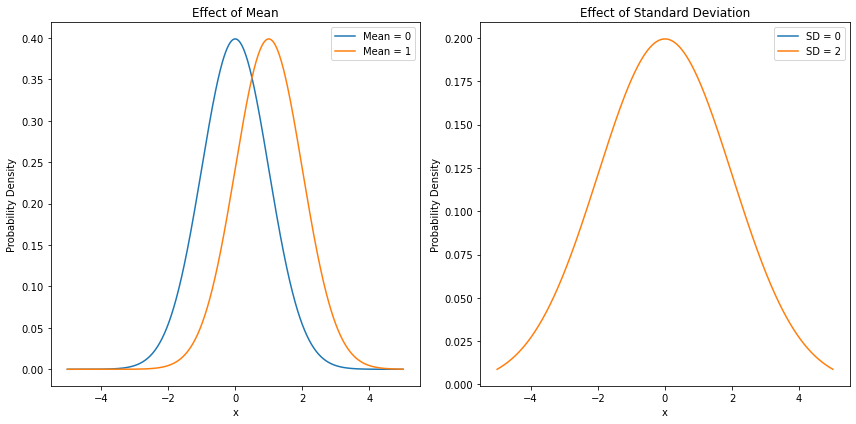

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
means = [0, 1]  # Different means
std_devs = [0, 2]  # Different standard deviations

# Generate values
x = np.linspace(-5, 5, 1000)

plt.figure(figsize=(12, 6))

# Plot different means
plt.subplot(1, 2, 1)
for mu in means:
    y = (1/(np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) ** 2)))
    plt.plot(x, y, label=f'Mean = {mu}')
plt.title('Effect of Mean')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()

# Plot different standard deviations
plt.subplot(1, 2, 2)
for sigma in std_devs:
    y = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x / sigma) ** 2))
    plt.plot(x, y, label=f'SD = {sigma}')
plt.title('Effect of Standard Deviation')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()

plt.tight_layout()
plt.show()

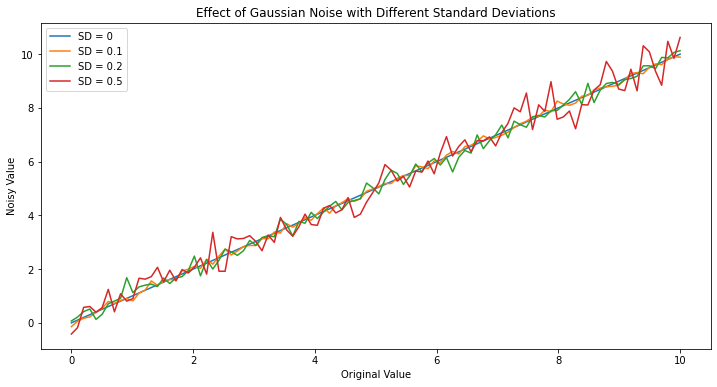

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create example data
np.random.seed(42)  # For reproducibility
original_data = pd.DataFrame({
    'value': np.linspace(0, 10, 100)  # Data ranging from 0 to 10
})

# Parameters for Gaussian noise
mean = 0
std_devs = [0, 0.1, 0.2, 0.5]  # Different standard deviations

plt.figure(figsize=(12, 6))

# Plot data with different levels of Gaussian noise
for std_dev in std_devs:
    noise = np.random.normal(loc=mean, scale=std_dev, size=original_data.shape[0])
    noisy_data = original_data['value'] + noise
    
    plt.plot(original_data['value'], noisy_data, label=f'SD = {std_dev}')

plt.title('Effect of Gaussian Noise with Different Standard Deviations')
plt.xlabel('Original Value')
plt.ylabel('Noisy Value')
plt.legend()
plt.show()

In [16]:
import pandas as pd

cols = []
EPC_count = 8

cols.append('EPC')

for i in range(1, 21):
    cols.append(f'gesture{i}')

df = pd.DataFrame(columns = cols)

for i in range(EPC_count):
    df.loc[i, 0] = f'A{i+1}'

print(df)

   EPC gesture1 gesture2 gesture3 gesture4 gesture5 gesture6 gesture7  \
0  NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1  NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2  NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
3  NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
4  NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
5  NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
6  NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
7  NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

  gesture8 gesture9  ... gesture12 gesture13 gesture14 gesture15 gesture16  \
0      NaN      NaN  ...       NaN       NaN       NaN       NaN       NaN   
1      NaN      NaN  ...       NaN       NaN       NaN       NaN       NaN   
2      NaN      NaN  ...       NaN       NaN       NaN       NaN       NaN   
3      NaN      NaN  ...      